# Notebook 02: Temperature Dependency of Acetogenic Yield 

This notebook is part of the research paper titled:

Optimizing acetogenic CO(2) utilization through metabolic and process engineering highlights the potential of thermophilic bioproduction

# Temperature Dependence of Acetogenesis Yield 

This notebook creates a thermodynamic-based black-box model of acetogenic growth and deduces various consumption, production, and growth yields as a fonction of temperature.

Notebook author: Philip J. Gorter de Vries

In [1]:
from os.path import dirname, join, pardir
from cobra.io import read_sbml_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
from scipy.optimize import curve_fit

# Define Process Parameters

In [2]:
R = 8.314 # [m^3*Pa/K/mol]

#Temperature range:
T0 = 273.15
dt = 80
T = np.arange(T0, T0+dt+1, 1)

def Kelvin_Celsius(t):
    """
    This function converts Temperature values from Kelvin to degrees Celsius
    """
    return t-273.15

def Celsius_Kelvin(t):
    """
    This function converts Temperature values from degrees Celsius to Kelvin
    """
    return t+273.15

# Deduce Acetogenic Yields

Acetogenic yields can be deduced from the overall reaction stoichiometries, which can be divided in two sub-rection: the anabolic reaction producing biomass from these substrates (eq. 21 & 22), and the catabolic reaction, releasing energy by production of acetate(eq. 19 & 20). Only acetate is considered as a product, and both carboxydotrophic and homoacetogenic growth are included.

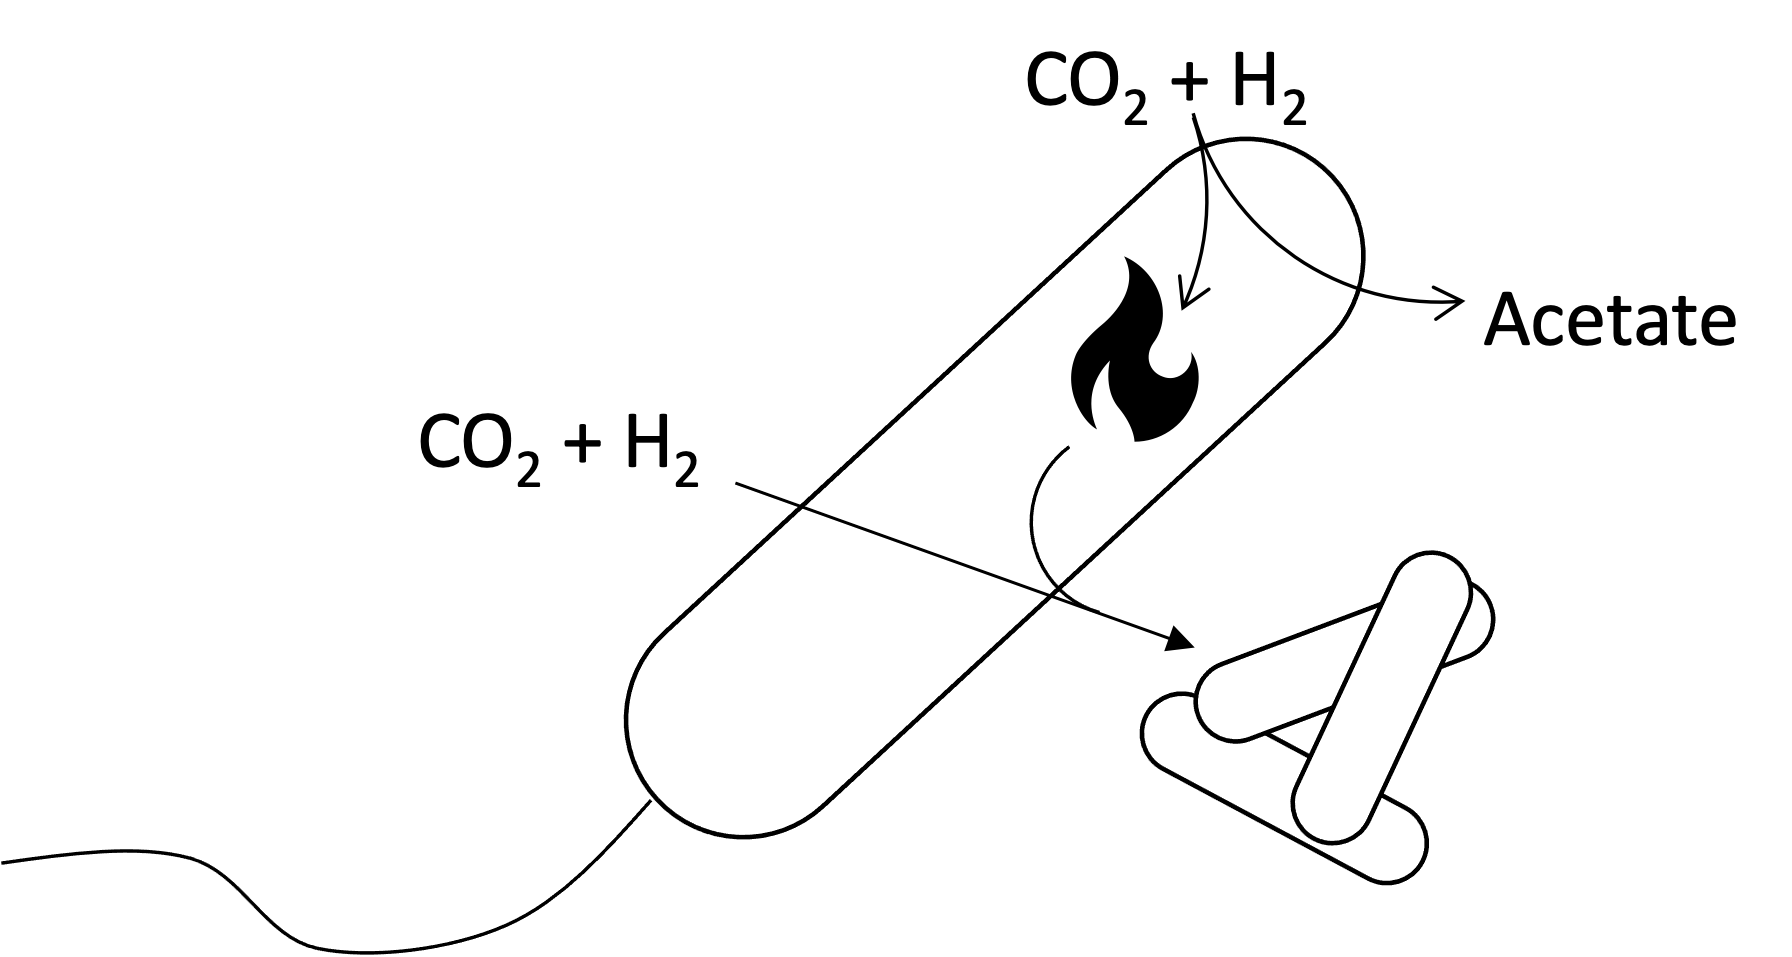

In [3]:
Image(filename='../Figures/ThermodynamicModelAnaCata.png', width = 500)

<p>Catabolic reaction stoichiometries:</p>

<p>$ 2 CO_2 + 4 H_2 <=> CH_3COOH + 2 H_2O $ 
    <span style="float:right;">(eq. 19)</span> </p>
<p>$ 4 CO + 2 H_2O <=> CH_3COOH + 2 CO_2 $
    <span style="float:right;">(eq. 20)</span> </p>

<p>Anabolic reaction stoichiometries:</p>

<p>$ CO_2 + 2.1 H_2 + 0.2 NH_3 <=> CH_{1.8}O_{0.5}N_{0.2} + 1.5 H_2O$
    <span style="float:right;">(eq. 21)</span>  </p>
<p>$ 2.1 CO + 0.6 H_2O + 0.2 NH_3 <=> CH_{1.8}O_{0.5}N_{0.2} + 1.1 CO_2$
    <span style="float:right;">(eq. 22)</span> </p>

# Calculate Gibbs Free Energy and Enthalpy of Reaction

With the anabolic and catabolic reactions determined, the next step is to add them up to find the overall reaction stoichiometry. For this purpose, a factor needs to be found to multiply the catabolic reaction by, to balance out the energy produced by catabolism with the energy required for anabolism, both as Growth-Associated Maintenance (GAM) and as Non-Growth-Associated Maintenance (NGAM). Firstly, the energy generated by the catabolic reaction is expressed as a function of temperature, using the Gibbs-Helmoltz equation (eq. 26).

<p>Gibbs free energy of reaction: </p>
<div style="text-align: center">  $ \Delta _r G^0 = \sum_i v_i * \Delta _fG_i^0$ [$kJ/mol$]
    <span style="float:right;">(eq. 24)</span>
</div>

<p>Reaction enthalpy: </p>
<div style="text-align: center">  $ \Delta _r H^0 = \sum_i v_i * \Delta _fH_i^0$ [$kJ/mol$]
    <span style="float:right;">(eq. 25)</span>
</div>

<p>Gibbs-Helmoltz equation: </p>
<div style="text-align: center">  $ \Delta _r G^T = \Delta _r G^0*(T/298.15) +\Delta _r H^0 * (1-T/298.15) $ [$kJ/mol$]
    <span style="float:right;">(eq. 26)</span>
</div>

Gibbs energy of reaction at standard temperature:
  DrGR_carb = -231.2 [kJ/mol]
  DrGR_hom = -152.5 [kJ/mol]
  DrGR_met = -184.7 [kJ/mol]

Enthalpy of reaction at standard temperature:
  DrHR_carb = -217.3 [kJ/mol]
  DrHR_hom = -253.6 [kJ/mol]
  DrHR_met = -250.4 [kJ/mol]



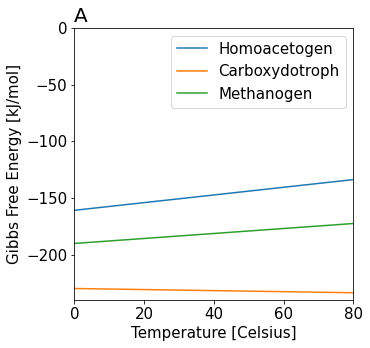

In [4]:
dfGR = pd.read_csv("../Data/EnthalpyGibbs.csv", encoding= 'unicode_escape', header=0, index_col="Compound", dtype = {"dfGR": float, "dfGR": float})["dfGR"]
dfHR = pd.read_csv("../Data/EnthalpyGibbs.csv", encoding= 'unicode_escape', header=0, index_col="Compound", dtype = {"dfGR": float, "dfGR": float})["dfHR"]

#Hess's law:
DrGR_carb = -4*dfGR["CO"] - 2*dfGR["Water"] + dfGR["Acetate"] + 2*dfGR["CO2"]
DrGR_hom = -4*dfGR["H2"] - 2*dfGR["CO2"] + dfGR["Acetate"] + 2*dfGR["Water"]
DrGR_met = -1*dfGR["CO2"] - 4*dfGR["H2"] + dfGR["Methane"] + 2*dfGR["Water"]

print("Gibbs energy of reaction at standard temperature:\n",
      " DrGR_carb =",round(DrGR_carb,1),"[kJ/mol]\n",
      " DrGR_hom =",round(DrGR_hom,1),"[kJ/mol]\n",
      " DrGR_met =",round(DrGR_met,1),"[kJ/mol]\n")

DrHR_carb = -4*dfHR["CO"] - 2*dfHR["Water"] + dfHR["Acetate"] + 2*dfHR["CO2"]
DrHR_hom = -4*dfHR["H2"] - 2*dfHR["CO2"] + dfHR["Acetate"] + 2*dfHR["Water"]
DrHR_met = -1*dfHR["CO2"] - 4*dfHR["H2"] + dfHR["Methane"] + 2*dfHR["Water"]

print("Enthalpy of reaction at standard temperature:\n",
      " DrHR_carb =", round(DrHR_carb,1),"[kJ/mol]\n",
      " DrHR_hom =", round(DrHR_hom,1),"[kJ/mol]\n",
      " DrHR_met =", round(DrHR_met,1),"[kJ/mol]\n")

#Gibbs–Helmholtz equation for temperature correction
def DrGT_carb(T):
    return DrGR_carb * (T/298.15) + DrHR_carb * (1-T/298.15)
def DrGT_hom(T):
    return DrGR_hom * (T/298.15) + DrHR_hom * (1-T/298.15)
def DrGT_met(T):
    return DrGR_met * (T/298.15) + DrHR_met * (1-T/298.15)

plt.figure(figsize=(5,5))
#plt.title(f"Gibbs Free Energy of Acetogenesis and Methanogenesis")
plt.title("A", fontdict = {'fontsize': 20}, loc = "left")
plt.axis([0, 80, -240, 0])
plt.xlabel('Temperature [Celsius]', fontsize=15)
plt.ylabel('Gibbs Free Energy [kJ/mol]', fontsize=15)
plt.plot(Kelvin_Celsius(T), DrGT_hom(T))
plt.plot(Kelvin_Celsius(T), DrGT_carb(T))
plt.plot(Kelvin_Celsius(T), DrGT_met(T))
plt.legend(['Homoacetogen','Carboxydotroph','Methanogen'], fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.show()

<p>Aerobic degradation of Acetate:</p>

<div style="text-align: center"> $ CH_3OOH + 2 O^2 => 2 CO_2 + 2 H_2O$<br>
$ \Delta _r G = -899.5$ [$kJ/mol$]
    <span style="float:right;">(eq. 31)</span>  </p>

# Calculate Non-Growth-Associated Maintenance Energy Requirements

Maintenance energy requirement can be split between GAM and NGAM. The former can be assumed to be 1000 kJ/Cmolbiomass, while for the latter, a temperature correlation has been found. Based on a wide range of studied anaerobic organisms, NGAM can be estimated through the temperature-dependent expression based on the Arrhenius expression, as proposed by Tijhuis et al. (eq. 23).


\[REF]: L. Tijhuis, M.C. M. van Loosdrecht, and J. J. Heijnen, A Thermodynamically Based Correlation for Maintenance Gibbs Energy Requirements in Aerobic and Anaerobic Chemotrophic Growth 

<p> NGAM: </p>
<div style="text-align: center">  $ m_{NGAM} = 3.3^{6900/R*(1/298-1/T)} $ [$kJ/h/Cmol_{biomass}$]
    <span style="float:right;">(eq. 23)</span>
</div>

In [5]:
def m_NGAM(T):
    """
    This function is the Arrhenius equation, as fit by Tijsen et al.
    """
    return 3.3**(69000/R*(1/298-1/T)) #[kJ/h/CmolX]

print("m_NGAM(300) =", round(m_NGAM(300),2), "[kJ/h/CmolX]")

m_NGAM(300) = 1.25 [kJ/h/CmolX]


In [6]:
# load data saved as csv, mostly from Thijhuis et al. DOI: 10.3389/fmicb.2015.01275

m_Anaerobes = pd.read_csv("../Data/m_Anaerobes.csv", encoding= 'unicode_escape', index_col="Species", dtype = {"Topt": float, "µ_max": float,"ToptK": float})
m_Anaerobes.head()

,Topt,mE,ToptK
Species,,,
Aerobacter aerogenes,37.0,12.20,310.15
Clostridium butyricum,35.0,15.60,308.15
Acetogenium kivui,60.0,20.60,333.15
Zymomonas mobilis,35.0,9.80,308.15
Saccharomyces cerevisiae,30.0,3.65,303.15


### Plot and fit to the Arrhenius equation

<p> The Arrhenius equation for max growth rate:</p>
<div style="text-align: center">  $ µ_{max} = A*T*e^{-B/(R*T)} $ [$h^{-1}$]
    <span style="float:right;">(eq. 27)</span>
</div>

In [7]:
def Arrhenius(T, A, B):
    """
    This function is the Arrhenius equation, as a function of temperature (T), with given constants A and B
    """
    return A * T * np.exp(-B/(R*T))
    
mE_popt, mE_pcov = curve_fit(Arrhenius, m_Anaerobes.drop("Acetogenium kivui").ToptK, m_Anaerobes.drop("Acetogenium kivui").mE)

#Acetogen kivui is an outlier, when included the model can't find a fit

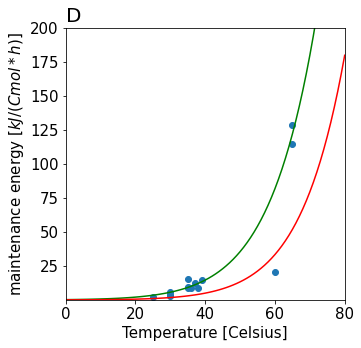

In [8]:
plt.figure(figsize=(5,5))
plt.title(f"D", fontdict = {'fontsize': 20}, loc = "left")
plt.axis([0, 80, 0.1, 200])
plt.xlabel('Temperature [Celsius]', fontsize=15)
plt.ylabel(r'maintenance energy [$kJ/(Cmol*h)$]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.plot(Kelvin_Celsius(T), Arrhenius(T, *mE_popt), 'g-', label='fit')
plt.plot(Kelvin_Celsius(T), m_NGAM(T), 'r-', label='fit')
plt.scatter(Kelvin_Celsius(m_Anaerobes.ToptK), m_Anaerobes.mE)
#plt.yscale('log')

plt.show()

# Calculate Growth-Associated Maintenance Energy Requirements

While GAM is not thought to be dependent on temperature, it can only be related to NGAM by multiplying it by the growth rate. Similarly to NGAM, µmax of organisms at their temperature optima seems to follow the Arrhenius equation. Maximum growth rates of known acetogens have thus been plotted by temperature and an Arrhenius equation was fit to the data.

\[REF] Heijnen J.J. (2010) Impact of Thermodynamic Principles in Systems Biology. In: Wittmann C., Krull R. (eds) Biosystems Engineering II. Advances in Biochemical Engineering / Biotechnology, vol 121. Springer, Berlin, Heidelberg. https://doi.org/10.1007/10_2009_63

In [9]:
m_GAM = 1000 #kJ/CmolX
print("m_GAM =", m_GAM, "[kJ/CmolX]")

m_GAM = 1000 [kJ/CmolX]


## Maximum growth rate temeprature dependence

In [10]:
# load data saved as csv, mostly from DOI: 10.3389/fmicb.2015.01275

µ_Acetogens = pd.read_csv("../Data/µ_Acetogens.csv", encoding= 'unicode_escape', index_col="Species", dtype = {"Topt": float, "mu_max": float, "ToptK": float})
µ_Acetogens.head()

,Topt,mu_max,ToptK
Species,,,
Rhodospirillum rubrum,30.0,0.20,303.15
Caldanaerobacter subterraneus,70.0,0.14,343.15
Carboxydocella sporoproducens,60.0,1.00,333.15
Carboxydocella thermoautotrophica,58.0,0.91,331.15
Carboxydothermus hydrogenoformans,70.0,0.50,343.15


A = 8.664637604856871, B = 24166.931701462072


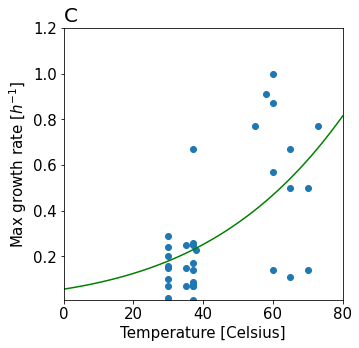

In [11]:
popt, pcov = curve_fit(Arrhenius, µ_Acetogens.ToptK, µ_Acetogens.mu_max)

print(f"A = {popt[0]}, B = {popt[1]}")

plt.figure(figsize=(5,5))
plt.title(f"C", fontdict = {'fontsize': 20}, loc = "left")
plt.axis([0, 80, 0.01, 1.2])
plt.xlabel('Temperature [Celsius]', fontsize=15)
plt.ylabel(r'Max growth rate [$h^{-1}$]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.plot(Kelvin_Celsius(T), Arrhenius(T, *popt), 'g-', label='fit')
plt.scatter(Kelvin_Celsius(µ_Acetogens.ToptK), µ_Acetogens.mu_max)
#plt.yscale('log')

def µ(T):
    return popt[0]*T*np.exp(-popt[1]/(R*T)) #[/h]

plt.show()

## Express Yields as temperature dependent functions

Combine the above temperature-dependent elements into overall stoichiometries and then into yields

In [12]:
def R_X(T):
    return 1

def R_CO_carb(T):
    return -4 * (-(m_NGAM(T)+m_GAM*µ(T))/DrGT_carb(T)) -2.1

def R_actt_carb(T):
    return -(m_NGAM(T)+m_GAM*µ(T))/DrGT_carb(T)

def R_H2_hom(T):
    return -4 * (-(m_NGAM(T)+m_GAM*µ(T))/DrGT_hom(T)) -2.1

def R_actt_hom(T):
    return -(m_NGAM(T)+m_GAM*µ(T))/DrGT_hom(T)

In [13]:
def Y_PS_carb(T):
    return -R_actt_carb(T)/R_CO_carb(T)
def Y_PS_hom(T):
    return -R_actt_hom(T)/R_H2_hom(T)
def Y_PX_carb(T):
    return R_actt_carb(T)/R_X(T)
def Y_PX_hom(T):
    return R_actt_hom(T)/R_X(T)
def Y_XS_carb(T):
    return -R_X(T)/R_CO_carb(T)
def Y_XS_hom(T):
    return -R_X(T)/R_H2_hom(T)

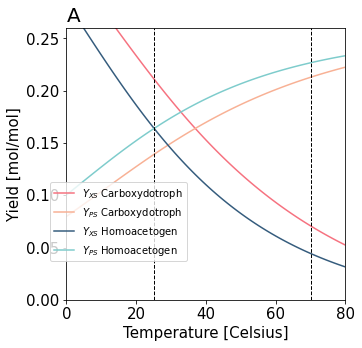

In [14]:
plt.figure(figsize=(5,5))
plt.title("A", fontdict = {'fontsize': 20}, loc = "left")
#plt.title(f"Yields of Acetogenesis on Electron donor")
plt.axis([0, 80, 0, 0.26])
plt.xlabel('Temperature [Celsius]', fontsize=15)
plt.ylabel('Yield [mol/mol]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.plot(Kelvin_Celsius(T), Y_XS_carb(T), color='#F67280')
plt.plot(Kelvin_Celsius(T), Y_PS_carb(T), color='#F8B195')
plt.plot(Kelvin_Celsius(T), Y_XS_hom(T), color='#355C7D')
plt.plot(Kelvin_Celsius(T), Y_PS_hom(T), color='#7ECCCC')
plt.axvline(x = 25, color = 'black', linestyle = '--', linewidth = 1)
plt.axvline(x = 70, color = 'black', linestyle = '--', linewidth = 1)
#plt.legend(['Y_PS Carboxydotroph','Y_PS Homoacetogenic'])
#plt.label(bbox_to_anchor = [0.5, 0.2])
plt.legend([r'$Y_{XS}$ Carboxydotroph',r'$Y_{PS}$ Carboxydotroph',r'$Y_{XS}$ Homoacetogen',r'$Y_{PS}$ Homoacetogen'],bbox_to_anchor=(0.45, 0.45))

plt.show()

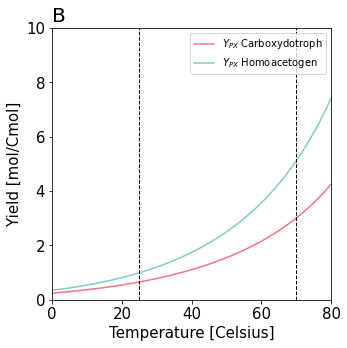

In [17]:
plt.figure(figsize=(5,5))
plt.title("B", fontdict = {'fontsize': 20}, loc = "left")
#plt.title(f"Product to biomass ratio in Acetogenesis")
plt.axis([0, 80, 0, 10])
plt.xlabel('Temperature [Celsius]', fontsize=15)
plt.ylabel('Yield [mol/Cmol]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.plot(Kelvin_Celsius(T), Y_PX_carb(T), color='#F67280')
plt.plot(Kelvin_Celsius(T), Y_PX_hom(T), color='#7ECCCC')
plt.axvline(x = 25, color = 'black', linestyle = '--', linewidth = 1)
plt.axvline(x = 70, color = 'black', linestyle = '--', linewidth = 1)
plt.legend([r'$Y_{PX}$ Carboxydotroph',r'$Y_{PX}$ Homoacetogen'])

plt.show()

In [16]:
T1 = Celsius_Kelvin(30)
T2 = Celsius_Kelvin(60)

print("Carboxydotrophic:")
print(f"Y_PS at {Kelvin_Celsius(T1)}°C and {Kelvin_Celsius(T2)}°C: {round(Y_PS_carb(T1),3)}, {round(Y_PS_carb(T2),3)}, change: {round(Y_PS_carb(T2)/Y_PS_carb(T1),3)}")
print(f"Y_XS at {Kelvin_Celsius(T1)}°C and {Kelvin_Celsius(T2)}°C: {round(Y_XS_carb(T1),3)}, {round(Y_XS_carb(T2),3)}, change: {round(Y_XS_carb(T2)/Y_XS_carb(T1),3)}")
print(f"Y_PX at {Kelvin_Celsius(T1)}°C and {Kelvin_Celsius(T2)}°C: {round(Y_PX_carb(T1),3)}, {round(Y_PX_carb(T2),3)}, change: {round(Y_PX_carb(T2)/Y_PX_carb(T1),3)}")

print("Homoacetogenic:")
print(f"Y_PS at {Kelvin_Celsius(T1)}°C and {Kelvin_Celsius(T2)}°C: {round(Y_PS_hom(T1),3)}, {round(Y_PS_hom(T2),3)}, change: {round(Y_PS_hom(T2)/Y_PS_hom(T1),3)}")
print(f"Y_XS at {Kelvin_Celsius(T1)}°C and {Kelvin_Celsius(T2)}°C: {round(Y_XS_hom(T1),3)}, {round(Y_XS_hom(T2),3)}, change: {round(Y_XS_hom(T2)/Y_XS_hom(T1),3)}")
print(f"Y_PX at {Kelvin_Celsius(T1)}°C and {Kelvin_Celsius(T2)}°C: {round(Y_PX_hom(T1),3)}, {round(Y_PX_hom(T2),3)}, change: {round(Y_PX_hom(T2)/Y_PX_hom(T1),3)}")

Carboxydotrophic:
Y_PS at 30.0°C and 60.0°C: 0.15, 0.201, change: 1.342
Y_XS at 30.0°C and 60.0°C: 0.191, 0.093, change: 0.488
Y_PX at 30.0°C and 60.0°C: 0.785, 2.158, change: 2.748
Homoacetogenic:
Y_PS at 30.0°C and 60.0°C: 0.174, 0.218, change: 1.252
Y_XS at 30.0°C and 60.0°C: 0.145, 0.061, change: 0.422
Y_PX at 30.0°C and 60.0°C: 1.205, 3.572, change: 2.964
